In [2]:
import csv
from pandas import *
import matplotlib.pyplot as plt 
import numpy as np
import math
import scipy.signal as sps

# PHONE: Y UP, X FORWARD, Z LATERAL
# BNO055: 

In [3]:
data = read_csv("Accelerometer.csv")
 
seconds_elapsed = data['seconds_elapsed'].tolist()
accelerometer_z = data['z'].tolist()
accelerometer_y = data['y'].tolist()
accelerometer_x = data['x'].tolist()

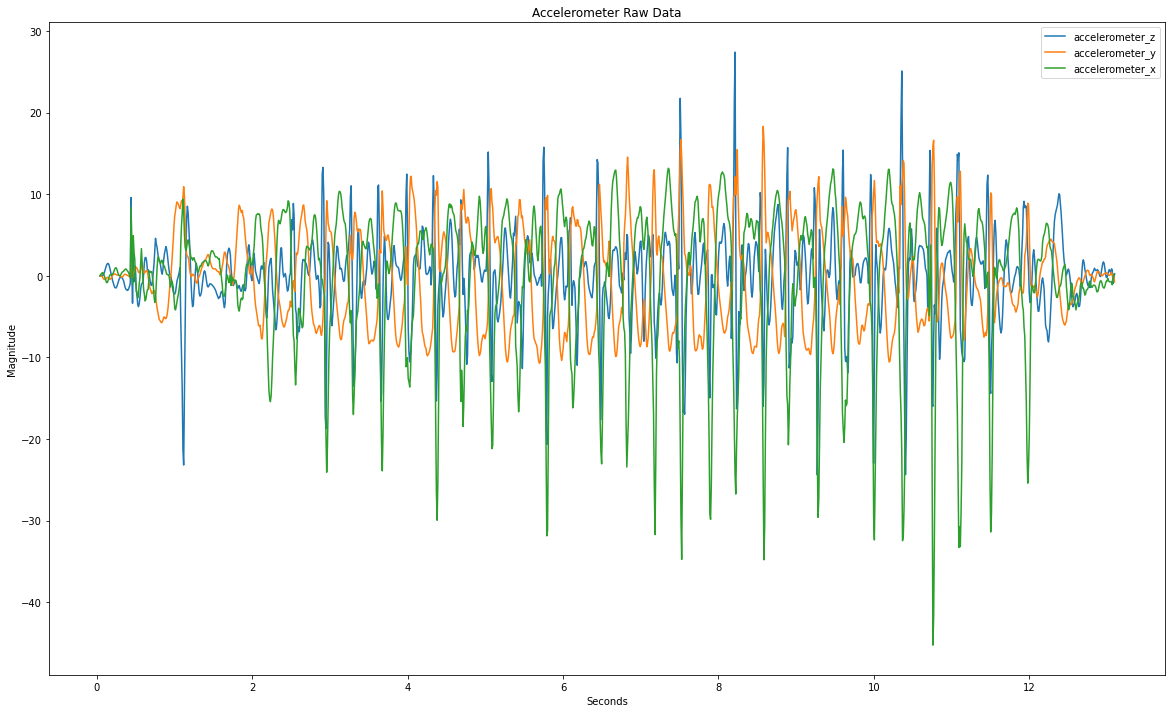

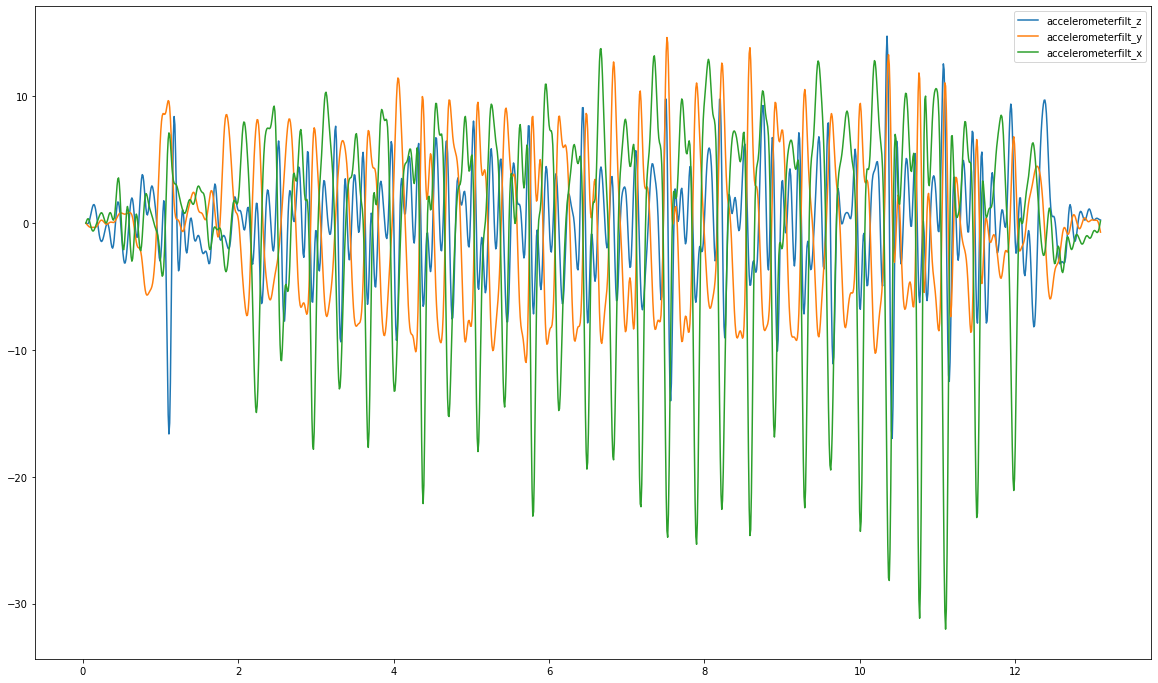

In [170]:
plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, accelerometer_z, label = "accelerometer_z") 
plt.plot(seconds_elapsed, accelerometer_y, label = "accelerometer_y") 
plt.plot(seconds_elapsed, accelerometer_x, label = "accelerometer_x") 
plt.xlabel("Seconds")
plt.ylabel("Magnitude")
plt.title("Accelerometer Raw Data")
plt.legend() 
plt.show()

#lowpass = 3/(100/2)
lowpass = 1*(20/100)

b2, a2 = sps.butter(6, lowpass, btype="lowpass")
xfilt = sps.filtfilt(b2, a2, accelerometer_x)
yfilt = sps.filtfilt(b2, a2, accelerometer_y)
zfilt = sps.filtfilt(b2, a2, accelerometer_z)

plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, zfilt, label = "accelerometerfilt_z") 
plt.plot(seconds_elapsed, yfilt, label = "accelerometerfilt_y") 
plt.plot(seconds_elapsed, xfilt, label = "accelerometerfilt_x") 
plt.legend() 
plt.show()


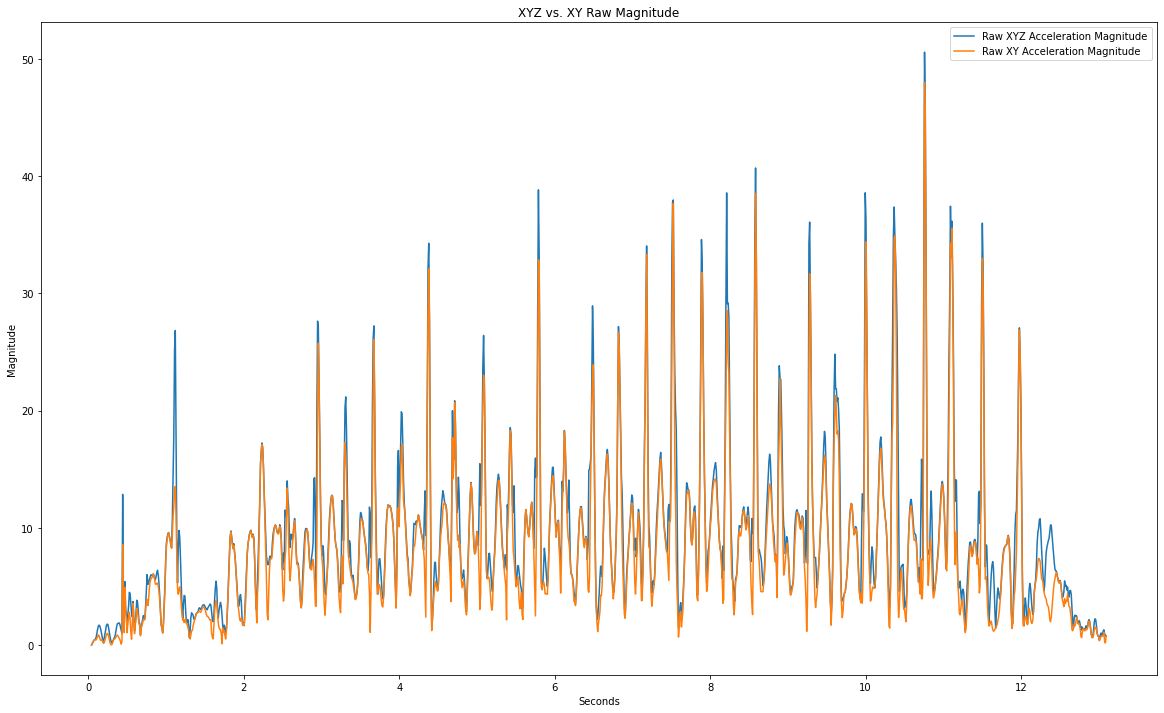

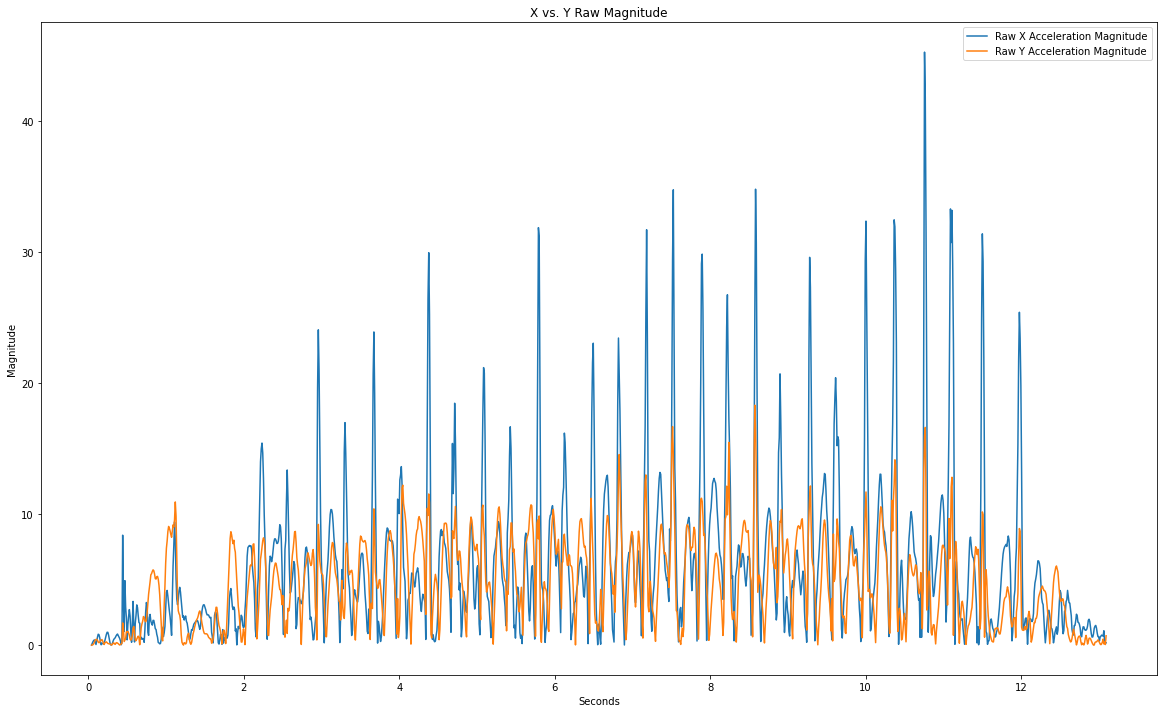

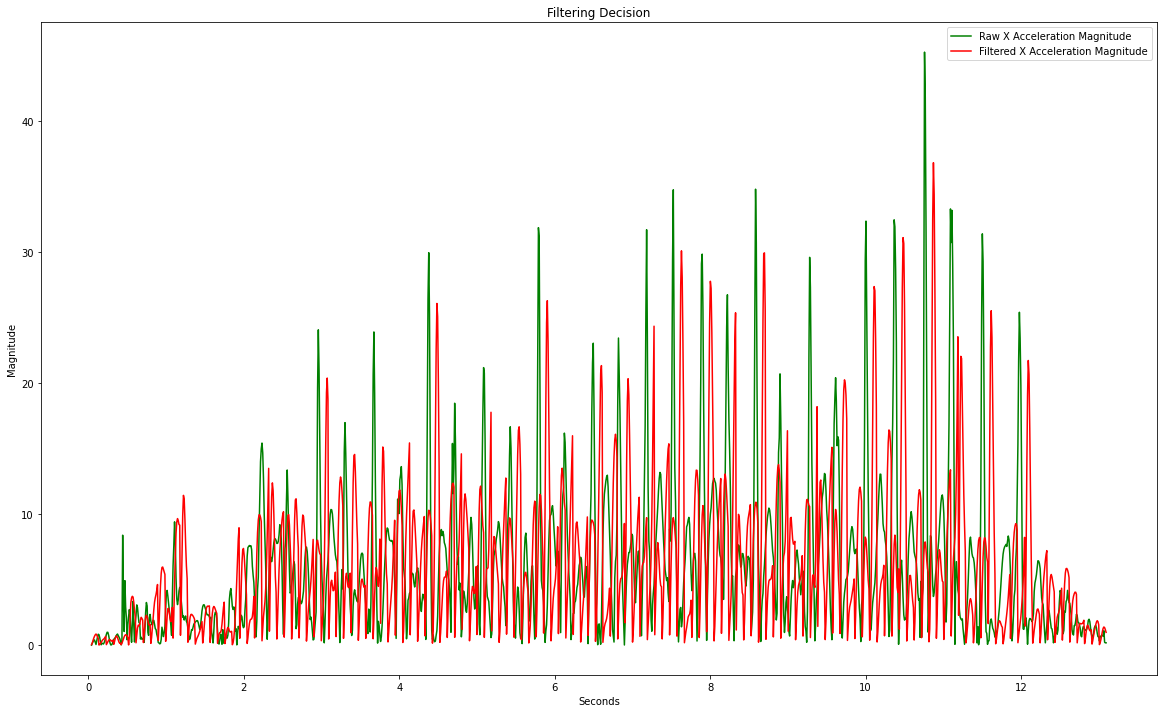

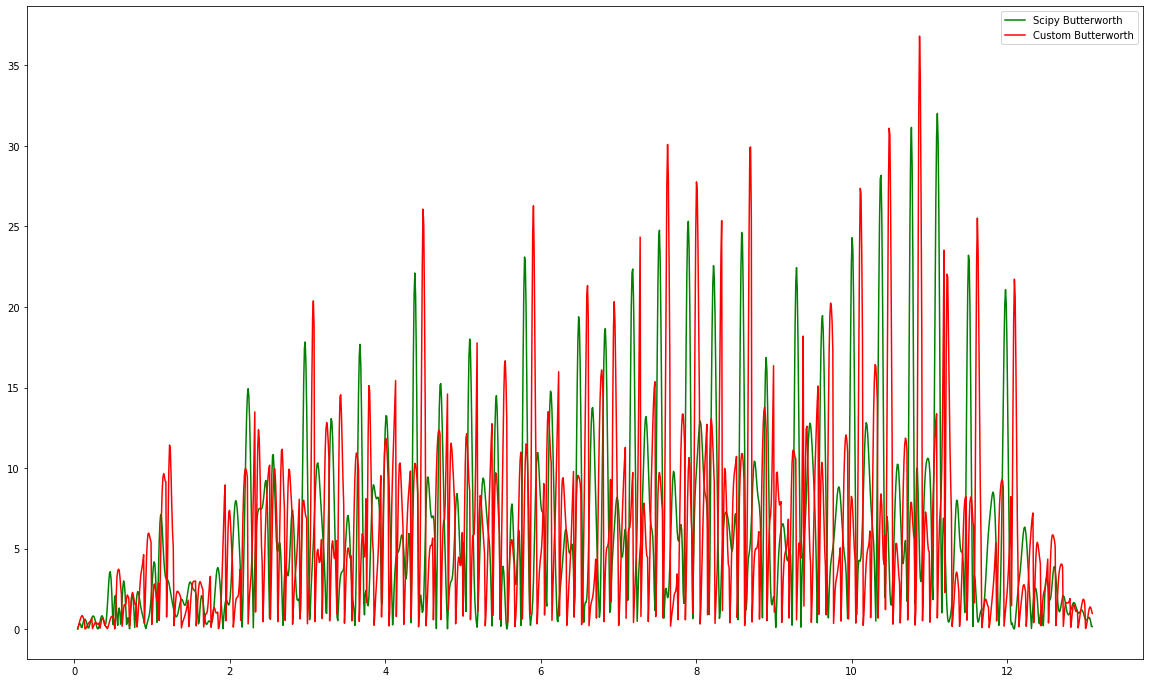

In [169]:
accel = []
acceltest = []
acceltestfilt = []
acceltestx = []
acceltesty = []
acceltestxfilt = []
acceltestyfilt = []
steps = []
for i in range(0, len(seconds_elapsed)):
    accel.append(math.sqrt( (accelerometer_x[i]*accelerometer_x[i]) + (accelerometer_y[i]*accelerometer_y[i]) + (accelerometer_z[i]*accelerometer_z[i]) ));
    acceltest.append(math.sqrt( (accelerometer_x[i]*accelerometer_x[i]) + (accelerometer_y[i]*accelerometer_y[i])));   
    acceltestfilt.append(math.sqrt( (xfilt[i]*xfilt[i]) + (yfilt[i]*yfilt[i])));   
    acceltestx.append(abs(accelerometer_x[i]))
    acceltesty.append(abs(accelerometer_y[i]))
    acceltestxfilt.append(abs(xfilt[i]))
    acceltestyfilt.append(abs(yfilt[i]))


filtb = [0.06396438, 0.12792877, 0.06396438]
filta = [-1.16826067,  0.42411821]

filtered = []
filtered2 = []

for i in range(0, len(seconds_elapsed)):
    if (i % 10 == 0):
        window = []
        a = [0,0,0]
        b = [0,0,0]
        for j in range(9,-1,-1):
            window.append(acceltest[i - j])
        for k in range(0, 10):
            a[0] = window[k]
            b[0] = filtb[0]*a[0] + filtb[1]*a[1] + filtb[2]*a[2] - filta[0]*b[1] - filta[1]*b[2]
            a[2] = a[1]
            a[1] = a[0]
            b[2] = b[1]
            b[1] = b[0]
            filtered.append(b[0])
        
        
        
plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, accel, label = "Raw XYZ Acceleration Magnitude") 
plt.plot(seconds_elapsed, acceltest, label = "Raw XY Acceleration Magnitude")
plt.xlabel("Seconds")
plt.ylabel("Magnitude")
plt.title("XYZ vs. XY Raw Magnitude")
plt.legend()
plt.show()

plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, acceltestx, label = "Raw X Acceleration Magnitude") 
plt.plot(seconds_elapsed, acceltesty, label = "Raw Y Acceleration Magnitude")
plt.xlabel("Seconds")
plt.ylabel("Magnitude")
plt.title("X vs. Y Raw Magnitude")
plt.legend()
plt.show()



plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, acceltestx, label = "Raw X Acceleration Magnitude", color="green")
plt.plot(seconds_elapsed, filtered, label = "Filtered X Acceleration Magnitude",color="red")
plt.xlabel("Seconds")
plt.ylabel("Magnitude")
plt.title("Filtering Decision")
plt.legend()
plt.show()

plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, acceltestxfilt, label = "Scipy Butterworth",color="green")
plt.plot(seconds_elapsed, filtered, label = "Custom Butterworth",color="red")
plt.legend()
plt.show()

29


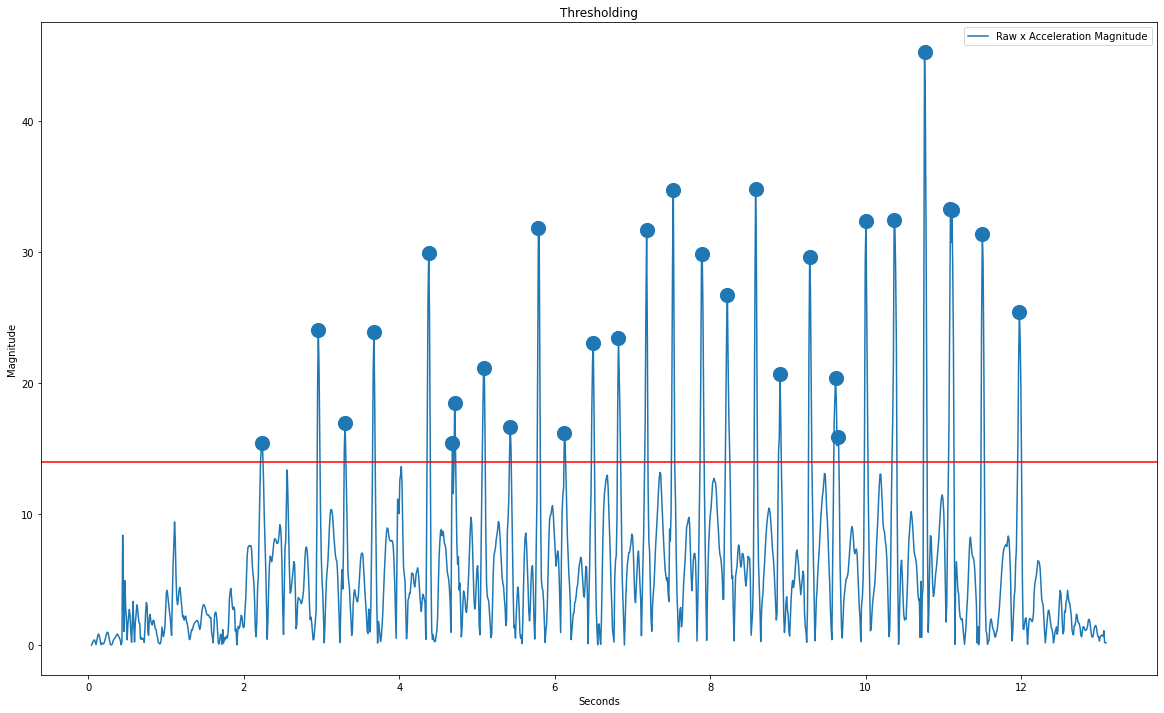

In [168]:
peaks_times = []
threshold = 14
peaks_indices = sps.find_peaks(acceltestx, height=threshold)[0]
peaks_values = (sps.find_peaks(acceltestx, height=threshold)[1]).get("peak_heights")
print(len(peaks_values))

for i in range(0, len(peaks_indices)):
    peaks_times.append(seconds_elapsed[peaks_indices[i]])
    




plt.figure(figsize=(20,12))
plt.plot(seconds_elapsed, acceltestx, label = "Raw x Acceleration Magnitude") 
plt.axhline(y = threshold, color = 'r', linestyle = '-') 
plt.scatter(peaks_times, peaks_values, s=200)
plt.xlabel("Seconds")
plt.ylabel("Magnitude")
plt.title("Thresholding")
plt.legend()
plt.show()

In [159]:
import numpy as np
from scipy import signal

freq_Hz = 100       # Frequency of overall IMU signal (Currently chosen arbitrarily)

#-----------------------------Continuous Transfer Function-------------------------------
wc = 2*np.pi*freq_Hz                # Cutoff Frequency
n = 2                               # Filter Order
                # Higher order: Better Filter but More Complexity (Longer Delay)
                        
# Compute Filter Coefficients
butter = np.zeros(n+1)
gamma = np.pi/(2*n)
butter[0] = 1
for i in range(n):
    temp = np.cos(i*gamma)/np.sin((i+1)*gamma)
    butter[i+1] = temp*butter[i]

denom = np.zeros(n+1)
for i in range(n+1):
    denom[n-i] = butter[i]/(wc**i)

coeffs_num = [1]
coeffs_den = denom
lowPass = signal.TransferFunction(coeffs_num, coeffs_den)
#----------------------------------------------------------------------------------------

# Discrete Transfer Function
fs = 1/1000        # Arbitrarily set sampling freq to 1kHz
lowPass_dis = lowPass.to_discrete(fs, method='gbt', alpha=0.5)

# Difference Equation Coefficients
b = lowPass_dis.num
a = lowPass_dis.den[1:]

print(b)
print(a)

[0.06396438 0.12792877 0.06396438]
[-1.16826067  0.42411821]
